# Bike Sharing in Washington D.C.

Two datasets from [Bike Sharing in Washington D.C.](https://www.kaggle.com/marklvl/bike-sharing-dataset/home) containing information about the Bike Sharing service in Washington D.C. "Capital Bikeshare" are provided.

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We will build a predictive model that can determine how many people will use the service on an hourly basis. We will use the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Modeling and Pipeline: Once we have the data, we create some features and then the modeling stage begins, making use of different models (and ensembles) and a strong pipeline with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set we decided to separate initially, then we review those results against their actual values to determine the performance of the model, and finally, outlining our conclusions.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tempfile import mkdtemp
from sklearn.base import clone
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from ml_helper.helper import Helper
from imblearn import FunctionSampler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import (
    PolynomialFeatures,
    KBinsDiscretizer,
    PowerTransformer,
    OneHotEncoder,
    FunctionTransformer,
)

warnings.filterwarnings("ignore")

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
MEMORY = mkdtemp()

KEYS = {
    "SEED": 1,
    "DATA_H": "https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv",
    "DATA_D": "https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv",
    "DATA_P": "https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv",
    "TARGET": "cnt",
    "METRIC": "r2",
    "TIMESERIES": True,
    "SPLITS": 3,
    "ESTIMATORS": 150,
    "MEMORY": MEMORY,
}

hp = Helper(KEYS)

### Data Loading

Here we load the necessary data, print its first rows and describe its contents.

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])


data = read_data(KEYS["DATA_H"])
data_daily = read_data(KEYS["DATA_D"])

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Precipitation Data

In order to generate our model, we will add precipitation data obtained from the [National Climatic Data Center.](https://www.ncdc.noaa.gov/cdo-web/datasets)

However, since most of the values are 0, we will convert them to a boolean that determines if rain was present or not at that specific hour.

In [5]:
precipitation = read_data(KEYS["DATA_P"])
data = pd.merge(data, precipitation, how="left", on=["dteday", "hr"])
data["precipitation"].fillna(0, inplace=True)
data["precipitation"][data["precipitation"] > 0] = 1
data["precipitation"] = data["precipitation"].astype(int).astype("category")

data_hourly = data.copy()
data_hourly = data_hourly[
    data_hourly["dteday"].isin(pd.date_range("2011-01-01", "2012-09-30"))
]

### Data types

We review the data types for each column.

In [6]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                    int64
yr                        int64
mnth                      int64
hr                        int64
holiday                   int64
weekday                   int64
workingday                int64
weathersit                int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Missing Data

We check if there is any missing data.

In [7]:
hp.missing_data(data)

,Total,Percent
precipitation,0,0.0
cnt,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0


### Converting columns to their true categorical type
Now we convert the data types of numerical columns that are actually categorical.

In [8]:
data = hp.convert_to_category(data, data.iloc[:, 2:10])

data.dtypes

instant                   int64
dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

We must specify that all of this analysis is performed only on the training data, so that we do not incur in any sort of bias when modeling.

To start we define some color palettes to be used.

In [9]:
palette_tot_cas_reg = ["darkgreen", "darkred", "darkblue"]

palette_cas = ["darkred", "salmon"]
palette_reg = ["darkblue", "skyblue"]

### Overall distribution of the target variable

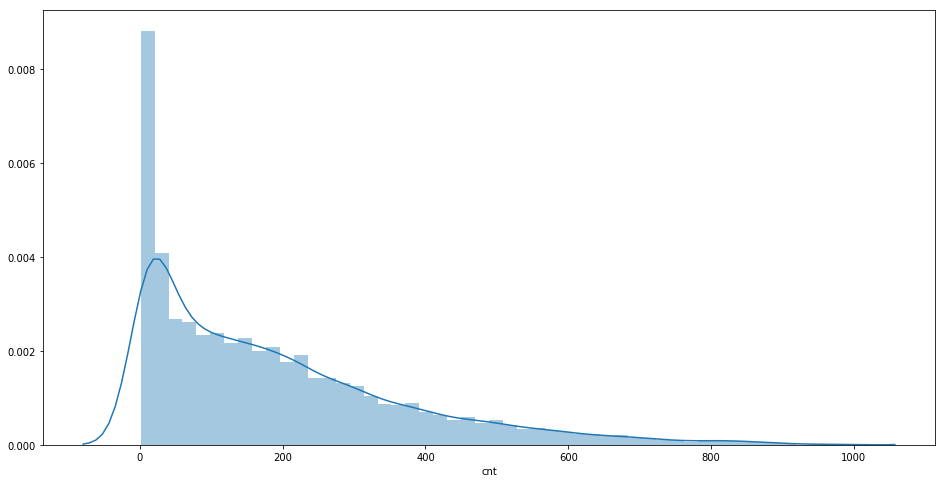

In [10]:
plt.figure(figsize=(16, 8))
sns.distplot(data["cnt"])

### Usage over time, by type of user and total

Text(0, 0.5, 'Users')

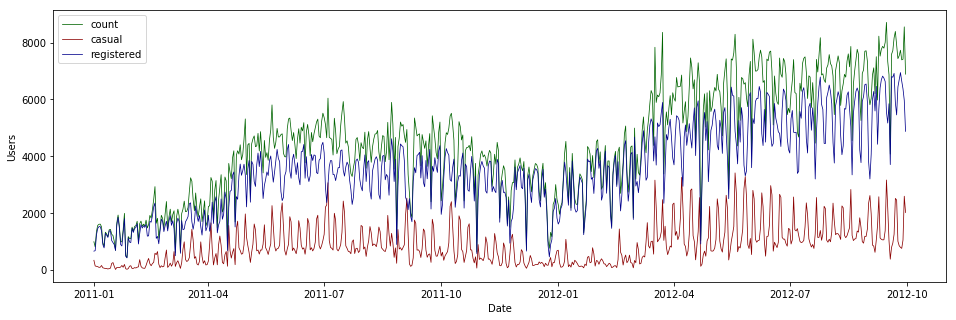

In [11]:
data_daily = data_daily[
    data_daily["dteday"].isin(pd.date_range("2011-01-01", "2012-09-30"))
]
data_daily = hp.convert_to_category(data_daily, data_daily.iloc[:, 2:9])
data_daily.set_index("dteday")

plt.figure(figsize=(16, 5))

ax = sns.lineplot(
    data=data_daily, x="dteday", y="cnt", color="darkgreen", size=1, label="count"
)
ax = sns.lineplot(
    data=data_daily, x="dteday", y="casual", color="darkred", size=1, label="casual"
)
ax = sns.lineplot(
    data=data_daily,
    x="dteday",
    y="registered",
    color="darkblue",
    size=1,
    label="registered",
)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(
    handles[0:1] + handles[3:4] + handles[6:7],
    labels[0:1] + labels[3:4] + labels[6:7],
    loc=2,
)
plt.xlabel("Date")
plt.ylabel("Users")

They all seem to be increasing and have some seasonality.

### Monthly average usage

Text(0, 0.5, 'Users')

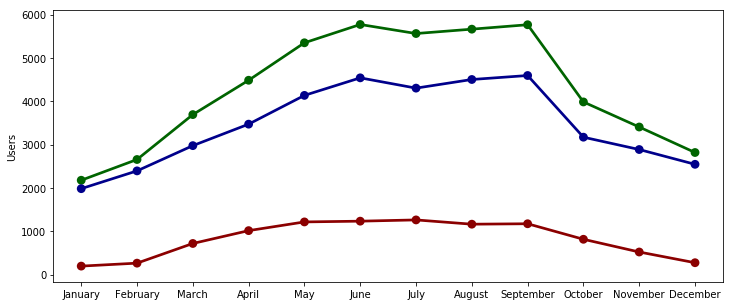

In [12]:
df_month = pd.DataFrame(
    data_daily.groupby("mnth")[["cnt", "casual", "registered"]].mean()
).reset_index()
months = pd.Series(
    [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
).rename("months")
df_month = pd.concat([df_month, months], axis=1)


plt.figure(figsize=(12, 5))
ax = sns.pointplot(data=df_month, x="months", y="cnt", color="darkgreen")
ax = sns.pointplot(data=df_month, x="months", y="casual", color="darkred")
ax = sns.pointplot(data=df_month, x="months", y="registered", color="darkblue")

plt.xlabel("")
plt.ylabel("Users")

No considerable differences in trends between casual and registered.

### Weekly trend usage

Text(0, 0.5, 'Users')

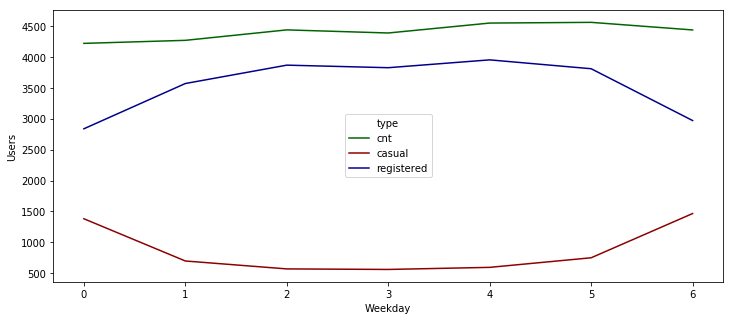

In [13]:
df_week = pd.DataFrame(
    data_daily.groupby("weekday")[["cnt", "casual", "registered"]].mean()
).reset_index()
df_week = pd.melt(
    df_week,
    id_vars=["weekday"],
    value_vars=["cnt", "casual", "registered"],
    var_name="type",
    value_name="users",
)

plt.figure(figsize=(12, 5))
ax = sns.lineplot(
    data=df_week, x="weekday", y="users", hue="type", palette=palette_tot_cas_reg
)
plt.xlabel("Weekday")
plt.ylabel("Users")

Casual and registered users follow exactly opposed trends throughout the week.

### Daily trend

By type of users:

Text(0, 0.5, 'Users')

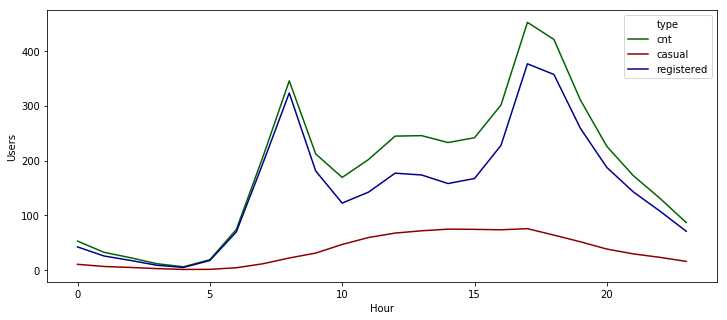

In [14]:
data_hourly = hp.convert_to_category(data_hourly, data_hourly.iloc[:, 2:9])
data_hourly.set_index("dteday")

df_day = pd.DataFrame(
    data_hourly.groupby("hr")[["cnt", "casual", "registered"]].mean()
).reset_index()
df_day = pd.melt(
    df_day,
    id_vars=["hr"],
    value_vars=["cnt", "casual", "registered"],
    var_name="type",
    value_name="users",
)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_day, x="hr", y="users", hue="type", palette=palette_tot_cas_reg)

plt.xlabel("Hour")
plt.ylabel("Users")

### Weekends compared with working days

Text(0, 0.5, 'Users')

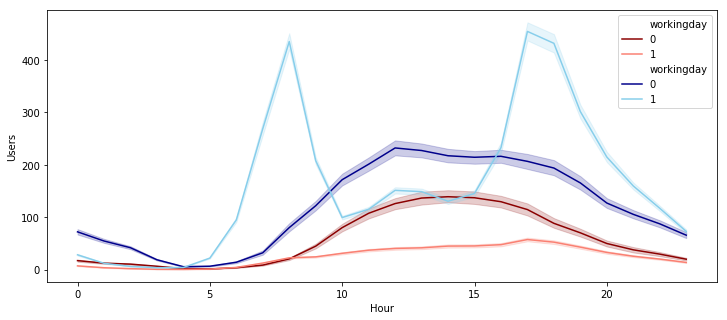

In [15]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=data_hourly, x="hr", y="casual", hue="workingday", palette=palette_cas
)
sns.lineplot(
    data=data_hourly, x="hr", y="registered", hue="workingday", palette=palette_reg
)
plt.xlabel("Hour")
plt.ylabel("Users")

### Temperature effect on casual users

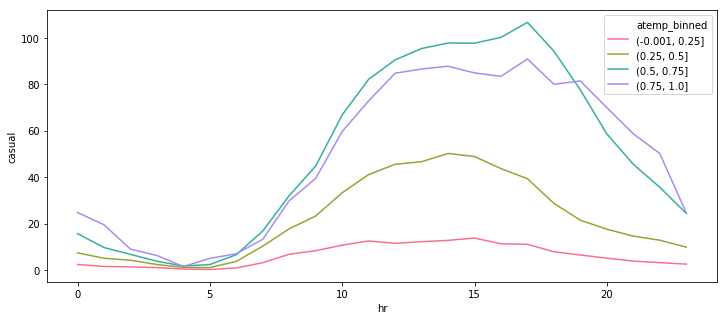

In [16]:
atemp_binned = pd.cut(x=data_hourly["atemp"], bins=4).rename("atemp_binned")
data_hourly_binned = pd.concat([data_hourly, atemp_binned], axis=1)

df_day_by_day_atemp = pd.DataFrame(
    data_hourly_binned.groupby(["hr", "atemp_binned"])[
        ["cnt", "casual", "registered"]
    ].mean()
).reset_index()
df_day_by_day_atemp.head()

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_day_by_day_atemp, x="hr", y="casual", hue="atemp_binned", palette="husl"
)

### Temperature effect on registered users

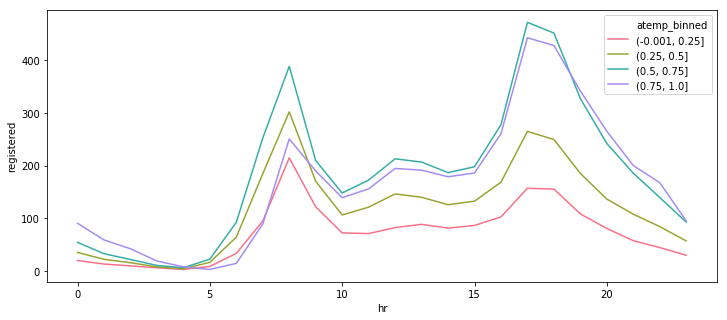

In [17]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_day_by_day_atemp, x="hr", y="registered", hue="atemp_binned", palette="husl"
)

As you can see, the effect is much more pronounced on the casual users.

### Temperature Vs. Usage on working days for casual users

Text(0.5, 1.0, 'Casual Users')

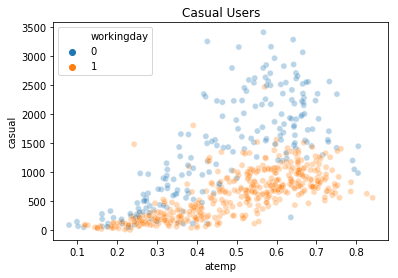

In [18]:
sns.scatterplot(data=data_daily, x="atemp", y="casual", hue="workingday", alpha=0.3)
plt.title("Casual Users")

### Temperature Vs. Usage on working days for registered users

Text(0.5, 1.0, 'Registered Users')

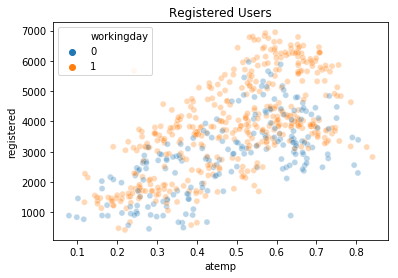

In [19]:
sns.scatterplot(data=data_daily, x="atemp", y="registered", hue="workingday", alpha=0.3)
plt.title("Registered Users")

As we can see, temperature does affect casual user usage, but registered users do not seem to mind the temperature.

### Precipitation Vs. Usage throughout the day

Text(0, 0.5, 'Users')

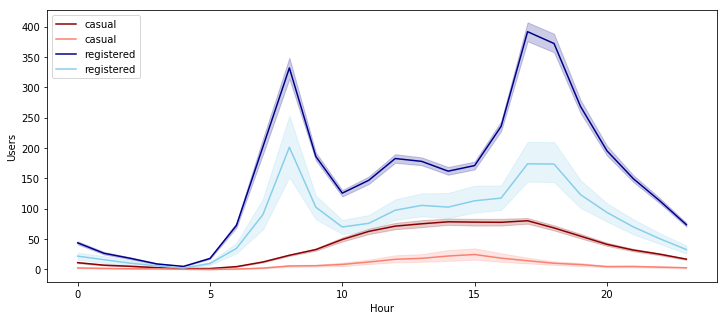

In [20]:
plt.figure(figsize=(12, 5))
ax = sns.lineplot(
    data=data_hourly,
    x="hr",
    y="casual",
    hue="precipitation",
    palette=palette_cas,
    label="casual",
)

ax = sns.lineplot(
    data=data_hourly,
    x="hr",
    y="registered",
    hue="precipitation",
    palette=palette_reg,
    label="registered",
)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2] + handles[5:7], labels[0:2] + labels[5:7], loc=2)
plt.xlabel("Hour")
plt.ylabel("Users")

### Boxplot of Numerical Variables

We review the distribution of scaled numerical data through a boxplot for each variable.

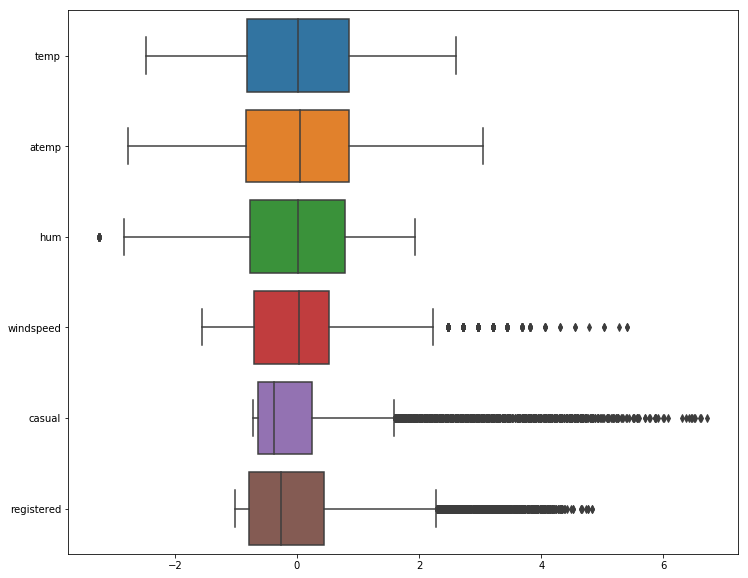

In [21]:
hp.boxplot(data, ["instant"])

From this we know that we should try some outlier treatment

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has. We will select columns that have a variance of less than 0.05 since they would probably perform poorly.

No invariant columns


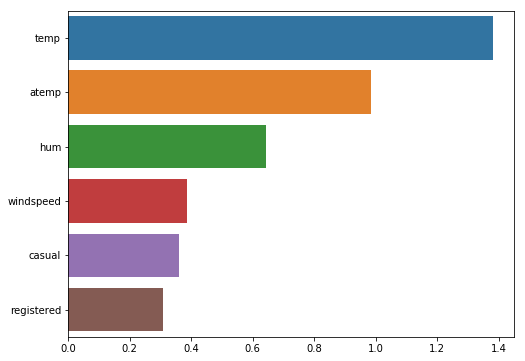

In [22]:
invariant = hp.coefficient_variation(data, threshold=0.05, exclude=["instant"])

## Baseline

A basic linear model is created in order to set a baseline, further models will be compared against its results.

In [23]:
base_holdout = data[
    data["dteday"].isin(pd.date_range("2012-10-01", "2012-12-31"))
].copy()
base_holdout = hp.drop_columns(base_holdout, ["dteday", "casual", "registered"])
base_data = data[data["dteday"].isin(pd.date_range("2011-01-01", "2012-09-30"))].copy()
base_data = hp.drop_columns(data, ["dteday", "casual", "registered"])

y, predictions = hp.predict(base_data, base_holdout, LinearRegression())
base_score = metric_scorer(y, predictions)
print("Baseline score: " + str(base_score))

Baseline score: 0.3165363882799508


### Data Correlation

Now we will analyze correlation in the data for both numerical and categorical columns and plot them, using a threshold of 90%.

The following columns are correlated with a threshold of 0.9: ['workingday', 'atemp', 'cnt']
The target variable is correlated, consider removing its correlated counterpart


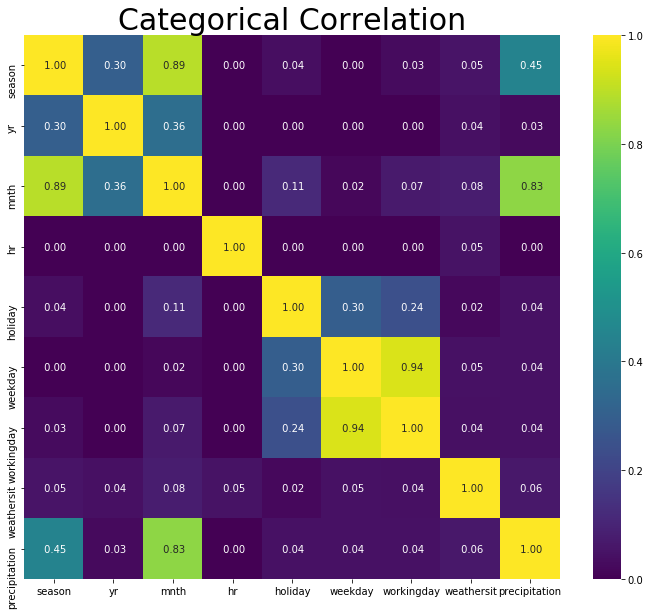

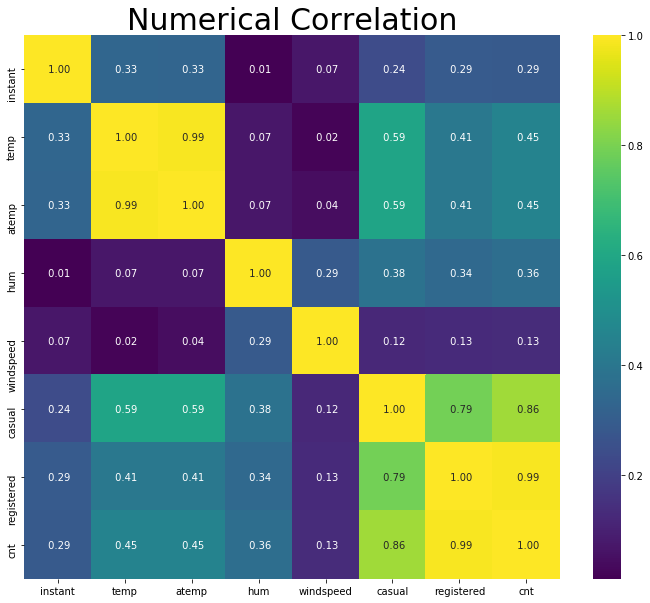

In [24]:
training_data = data[
    data["dteday"].isin(pd.date_range("2011-01-01", "2012-09-30"))
].copy()
correlated_cols = hp.correlated(training_data, 0.9)

### Underrepresented Features

Now we determine underrepresented features, meaning those that in more than 97% of the records are composed of a single value.

In [25]:
under_rep = hp.under_represented(data, 0.97)

['holiday'] underrepresented


### Principal Component Analysis (PCA)

We plot PCA component variance to define the number of components we wish to consider in the pipeline.

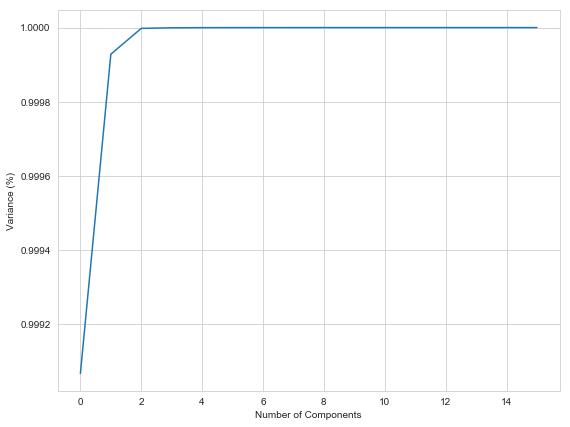

In [26]:
hp.plot_pca_components(data.drop("dteday", axis=1))

### Feature Importance

Here we plot feature importance using a random forest in order to get a sense of which features have the most importance.

Feature ranking:


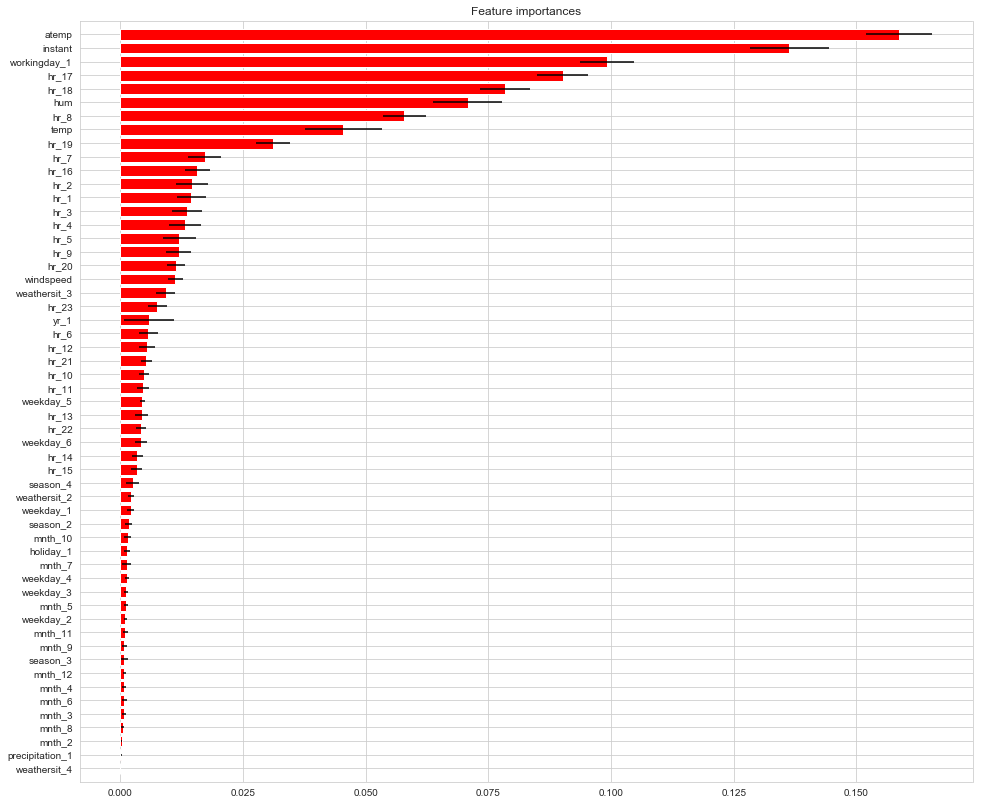

In [27]:
hp.feature_importance(
    hp.drop_columns(data, ["dteday", "registered", "casual"]),
    RandomForestRegressor(
        n_estimators=KEYS["ESTIMATORS"], random_state=KEYS["SEED"], n_jobs=-1
    ),
    convert=True,
)

### Defining Holdout Set for Validation

The first 5 quarters of the data will be used to train our model, while the remaining quarter will be used later on to validate the accuracy of our model.

In [28]:
holdout = (
    data[data["dteday"].isin(pd.date_range("2012-10-01", "2012-12-31"))]
    .copy()
    .reset_index()
)
holdout_final_plots = holdout.copy()  # we will use this for plots at the end
train_data = data[data["dteday"].isin(pd.date_range("2011-01-01", "2012-09-30"))]

## Feature Engineering / Pipeline / Modeling

A number of different combinations of feature engineering steps and transformations will be performed in a pipeline with different models, each one will be cross validated to review the performance of the model.

**Some of the steps are commented, the point is for the user to comment/uncomment the steps they wish to try and those pipelines and scores will be saved for later use**, that way you can see what improves the score and what decreases it.

Overall, we try removing unneeded columns, clustering, removing outliers through isolation forests, quantile binning, polynomial combinations, genetic transformations, one hot encoding, rebalancing techniques, recursive feature elimination, feature selection, PCA and more.

The pipeline uses the cross evaluation function, which handles time series splits for fold creation (instead of Kfolds which does not work for time series) while also setting a holdout to perform after the cross validation.

In [45]:
def day(df):
    df = df.copy()
    df["day"] = df["dteday"].dt.day
    df = hp.convert_to_category(df, ["day"])

    return df


def drop_features(df, cols):
    return df[df.columns.difference(cols)]


def kmeans(df, clusters=3):
    clusterer = KMeans(clusters, random_state=KEYS["SEED"])
    cluster_labels = clusterer.fit_predict(df)
    df = np.column_stack([df, cluster_labels])

    return df


def outlier_rejection(X, y):
    x = pd.DataFrame(X)
    y = pd.DataFrame(y)
    y_pred = IsolationForest(random_state=KEYS["SEED"], n_jobs=-1).fit_predict(X)

    return X[y_pred == 1], y[y_pred == 1]


num_pipeline = Pipeline(
    [
        ("power_transformer", PowerTransformer(method="yeo-johnson", standardize=True)),
        #     ('binning', KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense')),
        #     ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
        #     ('genetic', SymbolicTransformer(population_size=750, metric='spearman', function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'max', 'min'], parsimony_coefficient = 0.0005, max_samples = 0.9, random_state = KEYS['SEED']))
    ]
)

categorical_pipeline = Pipeline(
    [("one_hot", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

pipe = Pipeline(
    [
        ("day", FunctionTransformer(day, validate=False)),
        (
            "drop_features",
            FunctionTransformer(
                drop_features,
                kw_args={
                    "cols": ["dteday", "casual", "registered"]
                    + invariant
                    + correlated_cols
                    + under_rep
                },
                validate=False,
            ),
        ),
        (
            "column_transformer",
            ColumnTransformer(
                [
                    ("numerical_pipeline", num_pipeline, ["hum", "temp", "windspeed"]),
                    (
                        "categorical_pipeline",
                        categorical_pipeline,
                        [
                            "day",
                            "hr",
                            "mnth",
                            "precipitation",
                            "season",
                            "weathersit",
                            "weekday",
                            "yr",
                        ],
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        #     ('kmeans', FunctionTransformer(kmeans, validate=False)),
        #     ('outliers', FunctionSampler(func = outlier_rejection)),
        #     ('rfe', RFE(RandomForestRegressor(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED'], n_jobs = -1), n_features_to_select = 8)),
        #     ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED'], n_jobs = -1), threshold = 0.005)),
        ("pca", PCA(n_components=8)),
    ]
)

models = [
    {"name": "linear_regression", "model": LinearRegression()},
    {
        "name": "random_forest",
        "model": RandomForestRegressor(
            n_estimators=KEYS["ESTIMATORS"], random_state=KEYS["SEED"], n_jobs=-1
        ),
    },
    {"name": "xgb", "model": XGBRegressor(random_state=KEYS["SEED"])},
]

## Scores

Here you can see all of the scores throughout the entire cross validation process for each pipeline. To begin, we run three initial models with basic transformations and then add/remove transformers to see how the score moves. In certain cases errors can happen (for example when a certain fold contains a sparse matrix), therefore you may see errors marked as such in the score.

In [32]:
all_scores = hp.pipeline(train_data, models, pipe)

,Model,CV Score,Time,Steps,Note
0,linear_regression,0.590 +/- 0.000,2.963596,"day, drop_features, power_transformer, one_hot",
1,random_forest,0.750 +/- 0.053,10.960321,"day, drop_features, power_transformer, one_hot",
2,xgb,0.659 +/- 0.028,4.122353,"day, drop_features, power_transformer, one_hot",


Now we run the different combinations of pipelines with different combinations

In [46]:
all_scores = hp.pipeline(train_data, models, pipe, all_scores)

,Model,CV Score,Time,Steps,Note
0,linear_regression,0.590 +/- 0.000,2.963596,"day, drop_features, power_transformer, one_hot",
1,random_forest,0.750 +/- 0.053,10.960321,"day, drop_features, power_transformer, one_hot",
2,xgb,0.659 +/- 0.028,4.122353,"day, drop_features, power_transformer, one_hot",
3,linear_regression,0.592 +/- 0.000,0.362117,"day, drop_features, power_transformer, binning, one_hot",
4,random_forest,0.734 +/- 0.049,11.642595,"day, drop_features, power_transformer, binning, one_hot",
5,xgb,0.651 +/- 0.047,4.935440,"day, drop_features, power_transformer, binning, one_hot",
6,linear_regression,0.616 +/- 0.000,0.409417,"day, drop_features, power_transformer, binning, polynomial, one_hot",
7,random_forest,0.733 +/- 0.045,22.852619,"day, drop_features, power_transformer, binning, polynomial, one_hot",
8,xgb,0.643 +/- 0.044,10.579407,"day, drop_features, power_transformer, binning, polynomial, one_hot",
9,linear_regression,0.112 +/- 0.000,6.258051,"day, drop_features, power_transformer, binning, polynomial, one_hot, kmeans, outliers, pca",


### Pipeline Performance by Model

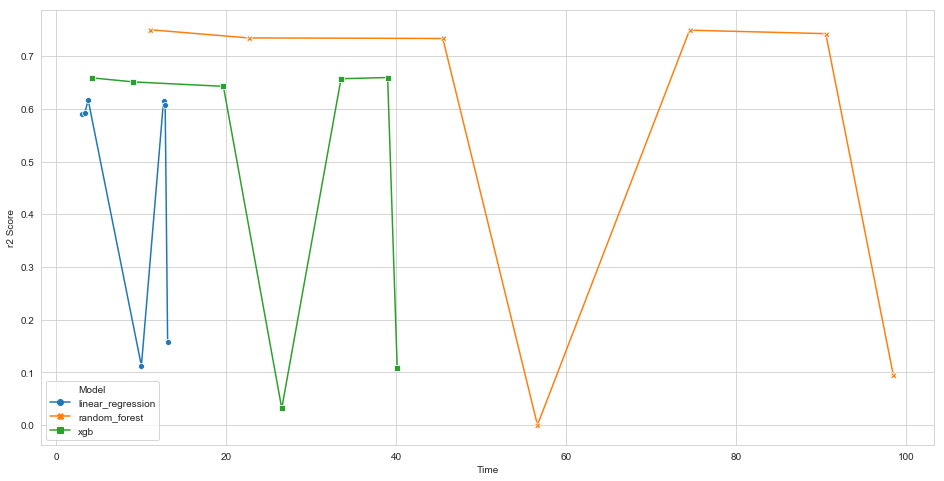

In [47]:
hp.plot_models(all_scores)

### Top Pipelines per Model

These are the top pipelines per model.

In [48]:
hp.show_scores(all_scores, top=True)

,CV Score,Time,Steps,Note
Model,,,,
linear_regression,0.616 +/- 0.000,0.409417,"day, drop_features, power_transformer, binning, polynomial, one_hot",
random_forest,0.750 +/- 0.053,10.960321,"day, drop_features, power_transformer, one_hot",
xgb,0.659 +/- 0.028,5.484647,"day, drop_features, power_transformer, polynomial, one_hot",


## Randomized Grid Search

Once we have a list of models, we perform a cross validated, randomized grid search on the best performing one to define the final models.

In [4]:
rf_grid = {
    "random_forest__criterion": ["mse", "mae"],
    "random_forest__max_depth": [50, 100],
    "random_forest__min_samples_leaf": [5, 10],
    "random_forest__min_samples_split": [10, 20],
    "random_forest__max_leaf_nodes": [None, 80],
}

final_scores, f_pipe = hp.cross_val(
    train_data, model=clone(hp.top_pipeline(all_scores)), grid=rf_grid
)
final_scores.mean()

0.6532984890000001

In [5]:
print(f_pipe.best_params_)
final_pipe = f_pipe.best_estimator_

{'random_forest__min_samples_split': 20, 'random_forest__min_samples_leaf': 5, 'random_forest__max_leaf_nodes': None, 'random_forest__max_depth': 50, 'random_forest__criterion': 'mae'}


From the scores obtained, we see that the performance of the model worsened, therefore we will stick to the original values

# Results
This is the final R^2 score of the best pipeline, tested against the holdout set.

In [58]:
y, predictions = hp.predict(train_data, holdout, clone(hp.top_pipeline(all_scores)))
score = metric_scorer(y, predictions)
score

0.8159291224850319

## Plots of Predictions

Here we plot the different results obtained.

For this scatter plot, the straighter the diagonal line is, the better the predictions since they are closer to the actual values.

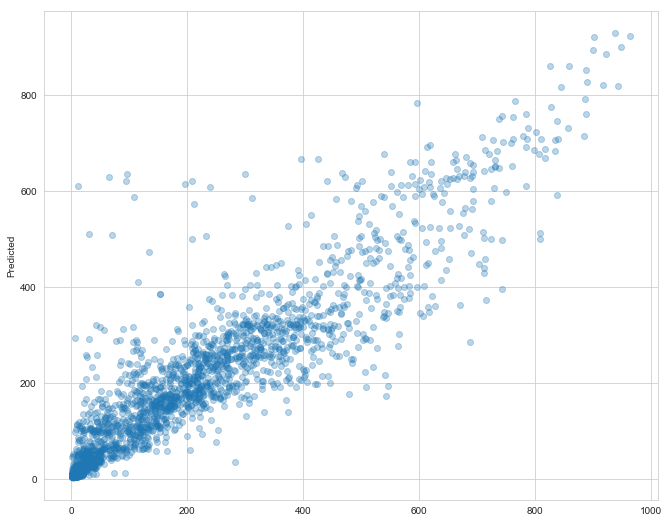

In [59]:
hp.scatter_predict(y, predictions)

### Hourly Three week prediction vs. reality plot

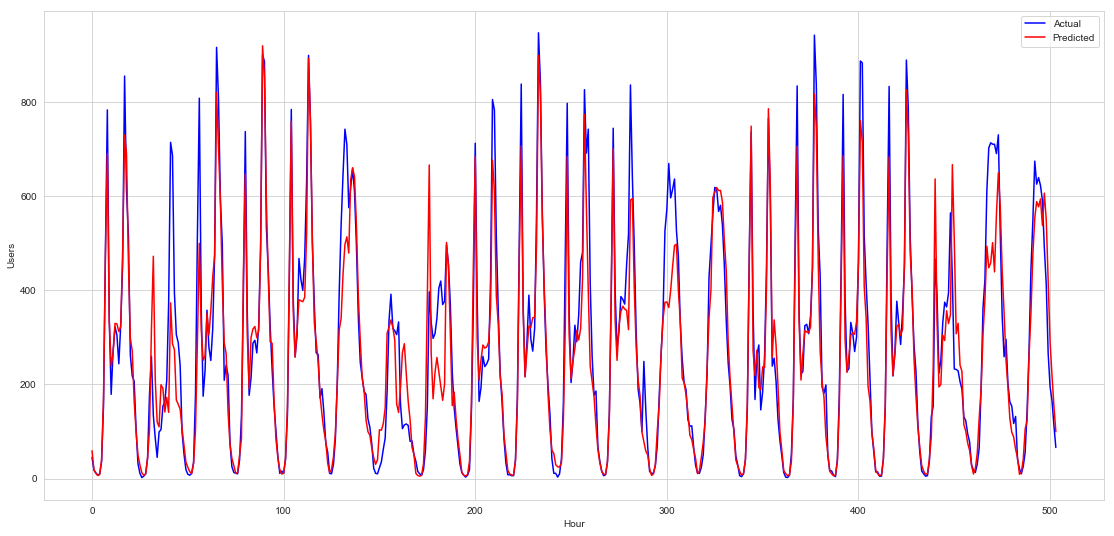

In [60]:
hp.plot_predict(y, predictions, subset=(3 * 7 * 24), x_label="Hour", y_label="Users")

### Entire daily predictions vs. reality plot

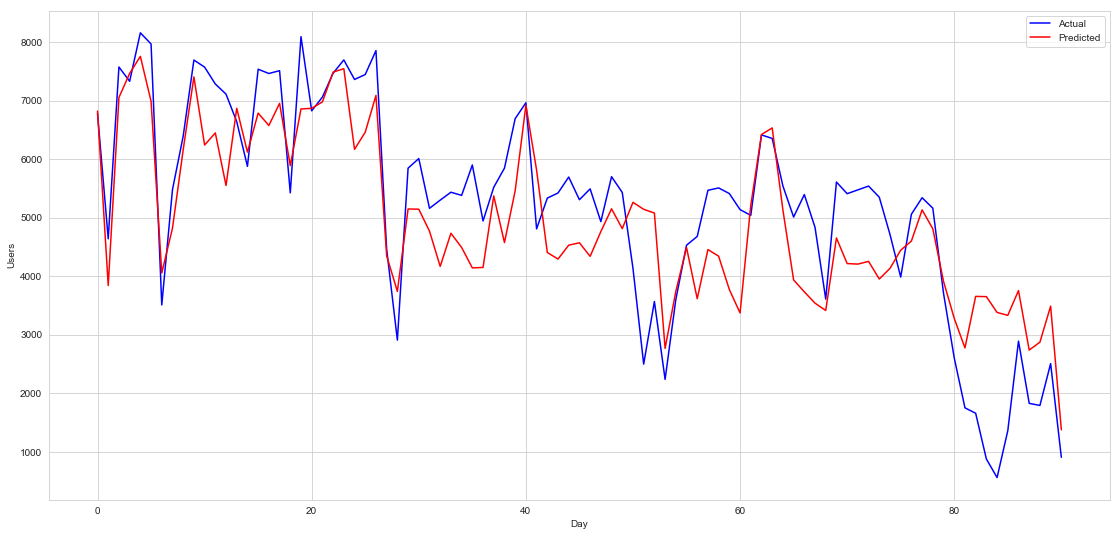

In [61]:
hp.plot_predict(y, predictions, group=24, x_label="Day", y_label="Users")

# Conclusions

We created a model that, based on certain parameters, determine bike usage on an hourly basis, with these results we can provide an estimation of usage which can be of great importance for all of the involved parties.

One of the key findings is that there is a great difference in usage from weekends to normal working days, this situation would need to be considered by the company to supply the correct amount of bicicles depending on the day of the week, since the demand changes drastically. Then, as can be guessed, temperature plays a big role in usage, although it is more significant in casual users.

Initially we had a baseline model with a very low r2 score, however, after performing multiple data preparation steps and transformations we achieved a much higher score, but not only that, we can see from the prediction plots that the model follows along many of the peaks and valleys of the real data, this proves that our predicting capabilities improved immensely.

Many different bike-sharing companies accross the world could use this model to estimate bike usage, planify better for expected demand and even help their governments transportation requirements. Measuring the impact of new bike infrastructure on cycling traffic and behavior is top of mind for many planners and advocacy groups.